In [181]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [182]:

df = pd.read_csv('preprocessed/df.csv')


# Missing values

## Identification of missing data

In [196]:
from util.constants import categorical_columns, numerical_columns, categorical_bool_columns, categorical_num_columns
def print_range_of_values(dataframe):
    for col in dataframe.columns:
        print(col, '\t',dataframe[col].unique())
        
print_range_of_values(df[categorical_columns])


rbc 	 [nan True False]
pc 	 [True False nan]
pcc 	 [False True nan]
ba 	 [False True nan]
htn 	 [True False nan]
dm 	 [True False nan]
cad 	 [False True nan]
appet 	 [True False nan]
pe 	 [False True nan]
ane 	 [False True nan]
class 	 [ True False]
sg 	 [1.02  1.01  1.005 1.015   nan 1.025]
al 	 [ 1.  4.  2.  3.  0. nan  5.]
su 	 [ 0.  3.  4.  1. nan  2.  5.]


In [197]:
def get_nr_none(dataframe):
    cols = []
    for col in dataframe.columns:
        total = len(df)
        none = np.count_nonzero(dataframe[col].isnull().values)
        ratio = none/total
        cols.append((col, total, none, ratio))
    return sorted(cols, key=lambda tup: tup[3], reverse=True)

def print_nr_none(dataframe):
    nr_none = get_nr_none(dataframe)
    print('column \t total \t none \t ratio')
    for col, total, none, ratio in nr_none:
        print(col, '\t', total, '\t', none, '\t', ratio)

In [198]:
print_nr_none(df)

column 	 total 	 none 	 ratio
rbc 	 400 	 152 	 0.38
rbcc 	 400 	 131 	 0.3275
wbcc 	 400 	 106 	 0.265
pot 	 400 	 88 	 0.22
sod 	 400 	 87 	 0.2175
pcv 	 400 	 71 	 0.1775
pc 	 400 	 65 	 0.1625
hemo 	 400 	 52 	 0.13
su 	 400 	 49 	 0.1225
sg 	 400 	 47 	 0.1175
al 	 400 	 46 	 0.115
bgr 	 400 	 44 	 0.11
bu 	 400 	 19 	 0.0475
sc 	 400 	 17 	 0.0425
bp 	 400 	 12 	 0.03
age 	 400 	 9 	 0.0225
pcc 	 400 	 4 	 0.01
ba 	 400 	 4 	 0.01
htn 	 400 	 2 	 0.005
dm 	 400 	 2 	 0.005
cad 	 400 	 2 	 0.005
appet 	 400 	 1 	 0.0025
pe 	 400 	 1 	 0.0025
ane 	 400 	 1 	 0.0025
class 	 400 	 0 	 0.0


#### Summary
- rbc (red blood cells [normal / abnormal]) has a missing value ratio of 43%
- rbcc (red blood cell count (numerical)) has a missing value ratio of 38%
- wbcc (white blood cell count) has a missing value ratio of 30%
- pot, sod, pcv have missing value ratios between 20% and 25%
- pc, hemo, su, sg, al, bgr have missing value ratios between 10% and 20%
- the rest have a missing value ratio of less than 6%.  

### Evaluating the dataset without missing values

In [245]:
df_without_nan = df.dropna()
df_without_nan.describe()


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,49.563291,74.050633,1.019873,0.797468,0.253165,131.341772,52.575949,2.188608,138.848101,4.636709,13.687342,41.917722,8475.949367,4.891772
std,15.512244,11.175381,0.005499,1.413130,0.813397,64.939832,47.395382,3.077615,7.489421,3.476351,2.882204,9.105164,3126.880181,1.019364
min,6.000000,50.000000,1.005000,0.000000,0.000000,70.000000,10.000000,0.400000,111.000000,2.500000,3.100000,9.000000,3800.000000,2.100000
25%,39.250000,60.000000,1.020000,0.000000,0.000000,97.000000,26.000000,0.700000,135.000000,3.700000,12.600000,37.500000,6525.000000,4.500000
50%,50.500000,80.000000,1.020000,0.000000,0.000000,115.500000,39.500000,1.100000,139.000000,4.500000,14.250000,44.000000,7800.000000,4.950000
75%,60.000000,80.000000,1.025000,1.000000,0.000000,131.750000,49.750000,1.600000,144.000000,4.900000,15.775000,48.000000,9775.000000,5.600000
max,83.000000,110.000000,1.025000,4.000000,5.000000,490.000000,309.000000,15.200000,150.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


From a total of 400 rows, 158 rows have no missing values. A lot of statistical power gets lost if all the nan values are dropped.

In [262]:
# Comparing the missing value ratios of the columns with their feature importance, maybe we can drop some columns with a high missing value ratio.
from sklearn.impute import SimpleImputer


X = df_without_nan.drop(columns=['class'])  # Exclude the target variable
y = df_without_nan['class']

# Create a Random Forest classifier object
rf = RandomForestClassifier()

# Fit the model on your data
rf.fit(X, y)

# Retrieve feature importances
importances = rf.feature_importances_


# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame in descending order of importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

   Feature  Importance
14    hemo    0.147973
15     pcv    0.144210
3       al    0.142418
11      sc    0.125475
17    rbcc    0.101485
2       sg    0.069417
10      bu    0.068937
18     htn    0.067159
19      dm    0.032099
6       pc    0.022098
9      bgr    0.016008
22      pe    0.015337
5      rbc    0.013890
16    wbcc    0.010465
4       su    0.007619
23     ane    0.003575
1       bp    0.003342
12     sod    0.002783
13     pot    0.001999
7      pcc    0.001597
8       ba    0.000979
0      age    0.000496
20     cad    0.000322
21   appet    0.000317


### Dropping columns

Since the column rbc has a missing value ratio of 43% and a relatively low importance (0.014), it is dropped.
Another argumentation is that rbc is just a classification of the column rbcc into 'normal' and 'abnormal', which means it has redundant information.

In [265]:
df.drop(columns=['rbc'], inplace=True)
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


## Removing NaN and None values by imputation
Due to the high dimensionaltiy of our data, a visualization of the missing values and its impact on the dataset to find out the missing value mechanism is not feasible.

To find out whether the missing values in this data set are MNAR, we would need to have measurements of some of the missing values. Since that is out of scope for our project, we assume that they are at least MAR. To be sure to have as little bias as possible, we will use multiple imputation methods to impute the missing values. We will use the mice package for this.

For the multiple imputation to work as intended, the dataset needs to be imputed as a whole. Categorical data and numerical cannot be imputed separately, otherwise correlations are not preserved. 

But since the mice model cannot deal with categorical data, we perform a one-hot encoding of the dataset.
nan values will appear as seperate columns since the one-hot encoder cannot deal with them. 

Therefore, we need to add the nan values separately afterwards.


Problem: how can categorical and numerical values be combined in one model? We cannot perform decision tree inputation on the numerical values and neither can we perform regression classification on the categorical values.
--> the data need to be treated seperately.

In [243]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier


# Create an instance of IterativeImputer with the desired estimator
imputer = IterativeImputer()
imputed = df.copy()
imputed_data = imputer.fit_transform(df)


In [240]:
from functools import reduce
imputed[df.columns] = imputed_data
imputed = imputed.round({'al': 0, 'su': 0, 'sg': 3})
imputed['sg'] = (imputed['sg'] / 0.005).round() * 0.005
imputed = imputed.round(reduce(lambda acc, col: {**acc, col: 0}, categorical_bool_columns, {}))

imputed
print(imputed['sg'].unique())

[1.02  1.01  1.005 1.015 1.025 0.995]


rbc
pc
pcc
ba
htn
dm
cad
appet
pe
ane
class
sg


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6,) and arg 1 with shape (5,).

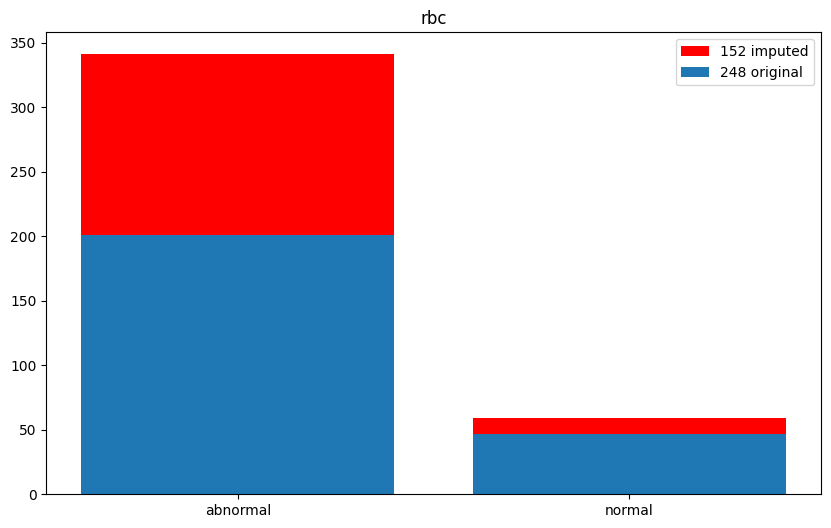

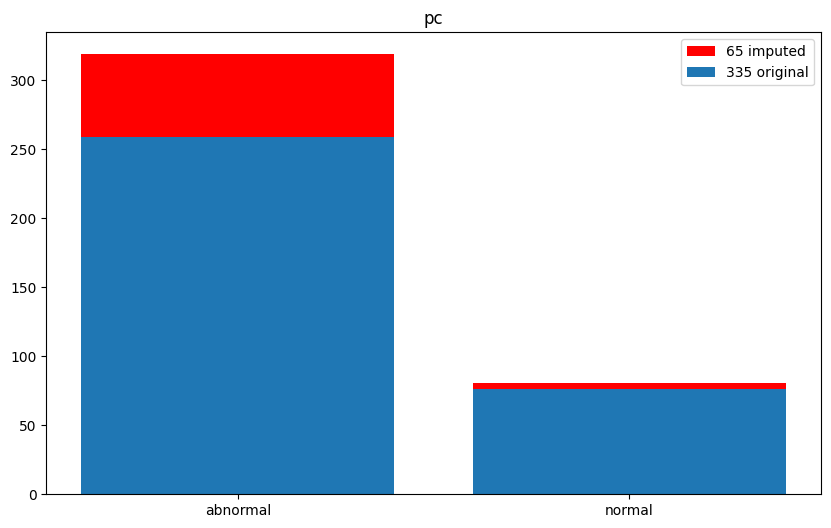

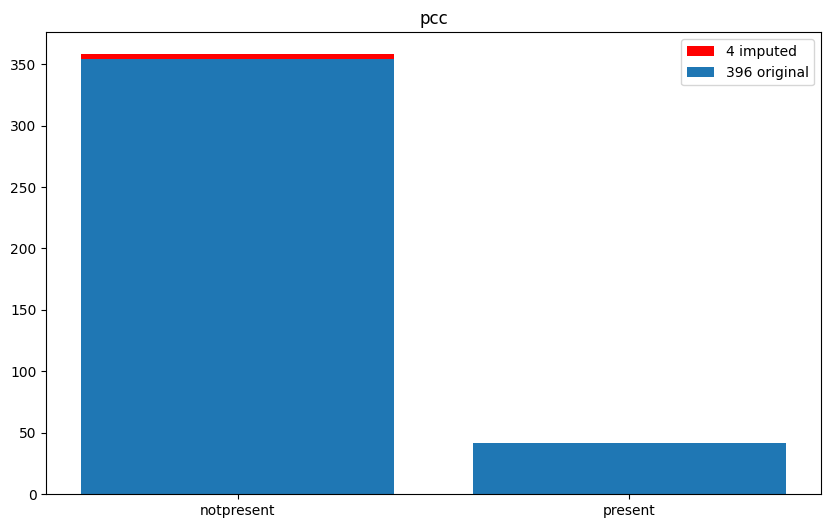

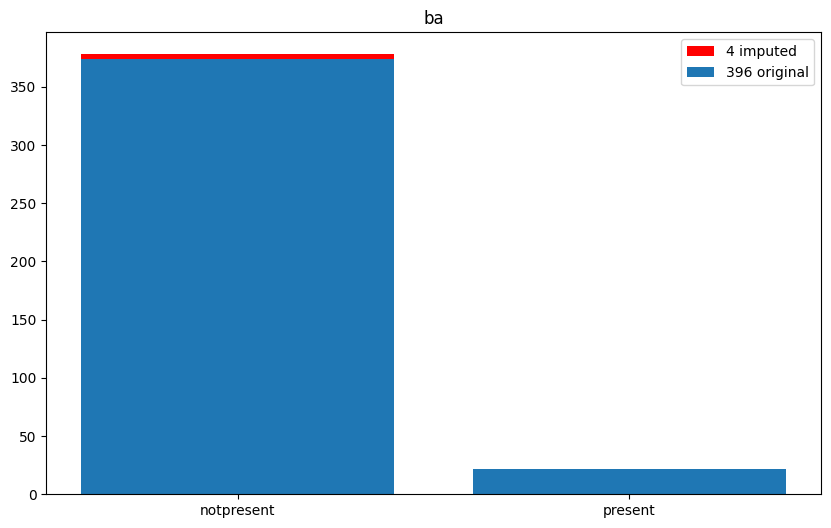

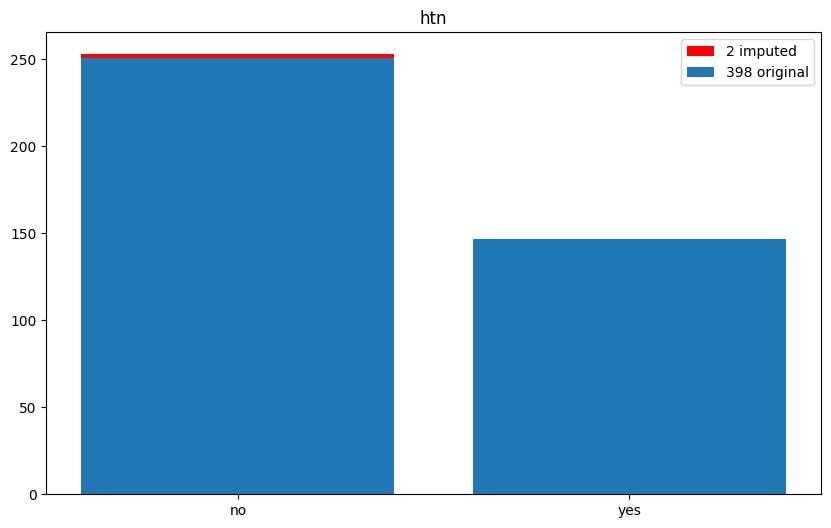

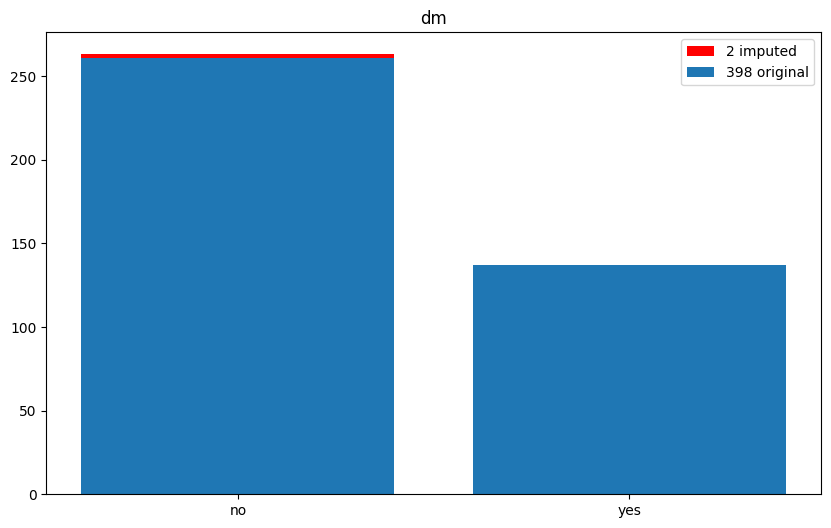

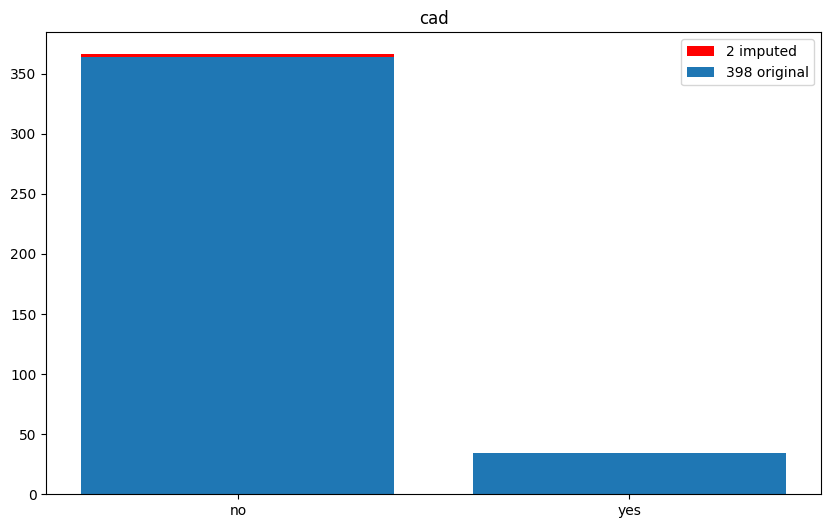

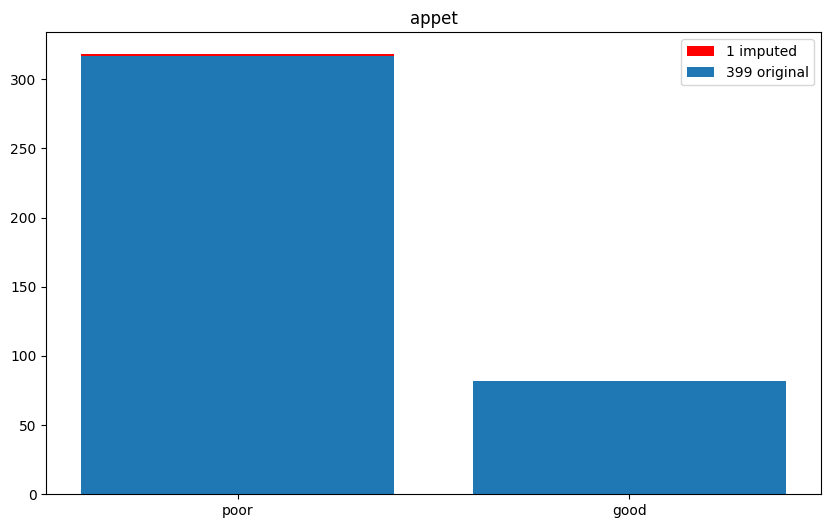

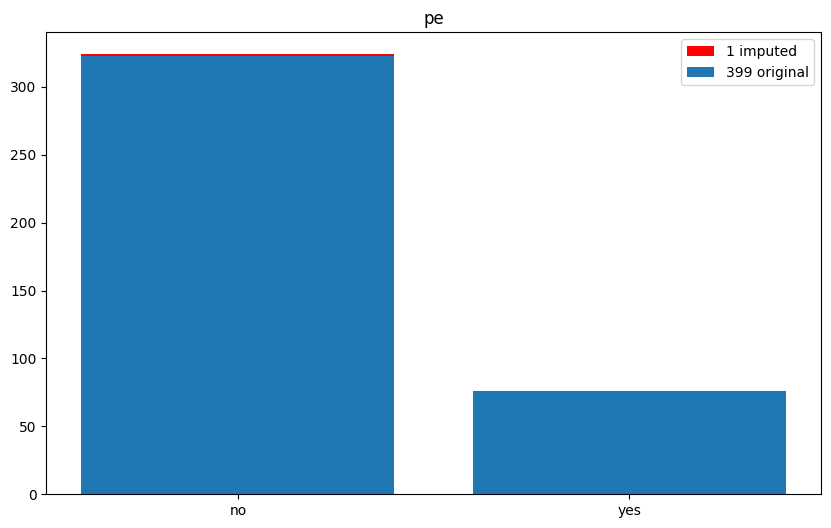

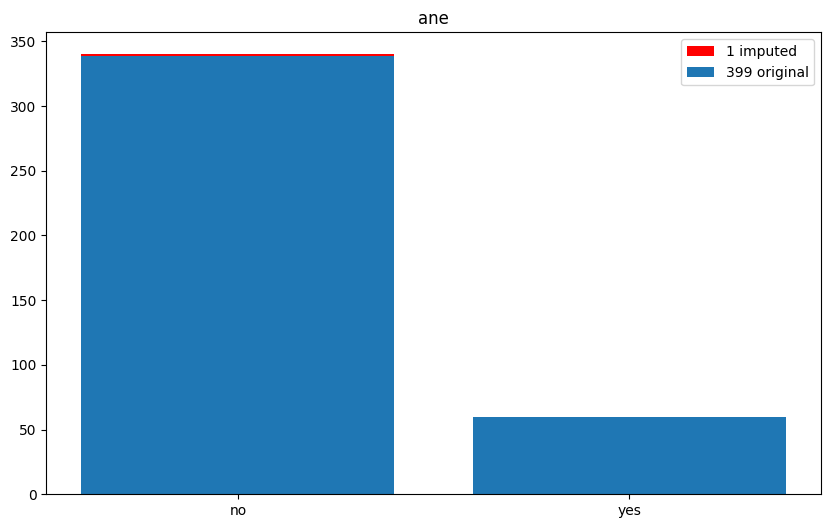

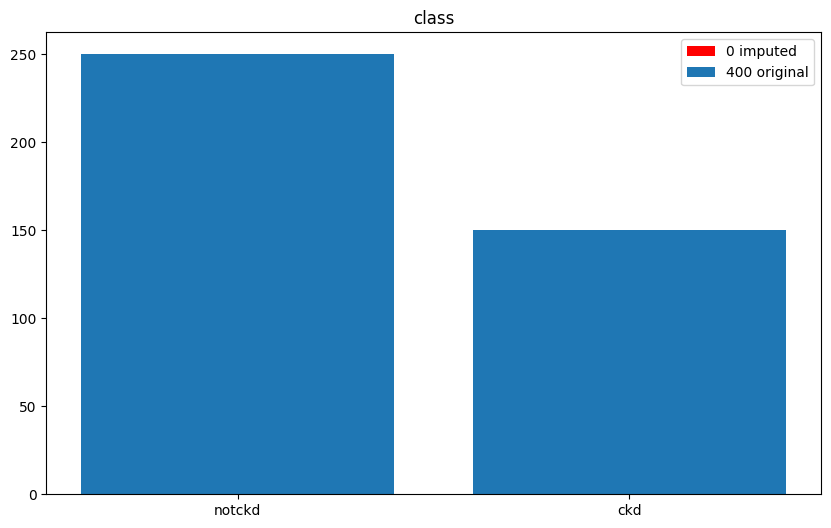

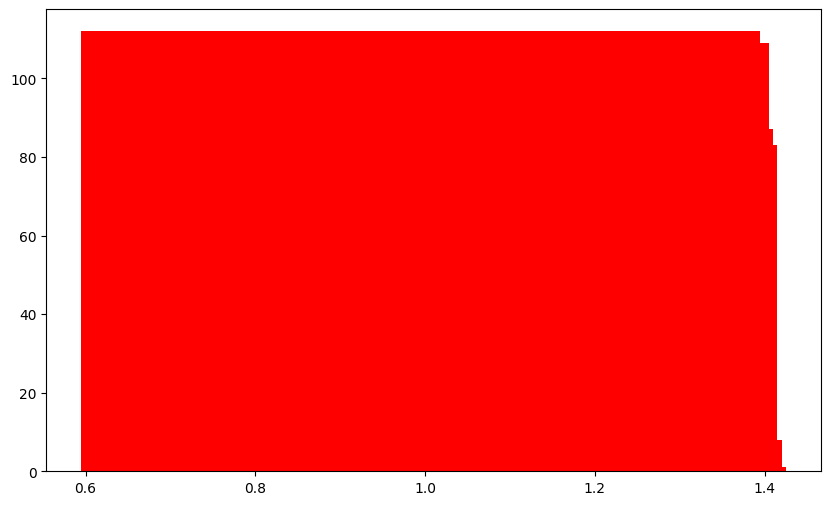

In [237]:
from util.constants import map_bool_to_val


for col in categorical_columns:
    print(col)
    categories = np.unique(imputed[col])
    if col in map_bool_to_val:
        categories = [ map_bool_to_val[col][c] for c in categories  if col in map_bool_to_val]

    original_counts = df[col].value_counts()
    imputed_counts = imputed[col].value_counts()
    
    plt.figure(figsize=(10, 6))
    plt.bar(categories, imputed_counts, label='Imputed', color='red')
    plt.bar(categories, original_counts, label='Original')
    
    plt.legend(['{imp} imputed'.format(imp = sum(imputed_counts) - sum(original_counts)), '{orig} original'.format(orig = sum(original_counts))])
    plt.title(col)

## Save to csv

In [225]:
df[categorical.columns] = categorical_imputed
df[numeric.columns] = numeric_imputed
df.to_csv('preprocessed/df_imputed.csv', index=False)  
df_check = pd.read_csv('preprocessed/df_imputed.csv')
print_nr_none(df_check)


column 	 total 	 none 	 ratio
age 	 400 	 0 	 0.0
bp 	 400 	 0 	 0.0
sg 	 400 	 0 	 0.0
al 	 400 	 0 	 0.0
su 	 400 	 0 	 0.0
rbc 	 400 	 0 	 0.0
pc 	 400 	 0 	 0.0
pcc 	 400 	 0 	 0.0
ba 	 400 	 0 	 0.0
bgr 	 400 	 0 	 0.0
bu 	 400 	 0 	 0.0
sc 	 400 	 0 	 0.0
sod 	 400 	 0 	 0.0
pot 	 400 	 0 	 0.0
hemo 	 400 	 0 	 0.0
pcv 	 400 	 0 	 0.0
wbcc 	 400 	 0 	 0.0
rbcc 	 400 	 0 	 0.0
htn 	 400 	 0 	 0.0
dm 	 400 	 0 	 0.0
cad 	 400 	 0 	 0.0
appet 	 400 	 0 	 0.0
pe 	 400 	 0 	 0.0
ane 	 400 	 0 	 0.0
class 	 400 	 0 	 0.0
